## Mount Google Drive

Start by mounting local Google Drive, which will be used to load and save files. 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Load the local folder (from Google Drive) that corresponds to the model of interest. 

In [3]:
import sys
# sys.path.append('/content/drive/My Drive/Colab Notebooks/InverseOptimizationFBA/ecoli_small')
sys.path.append('/content/drive/My Drive/Work/Project/BO4IO/BO4IO/case_study/FBA/ecoli_small')

Change the current directory to the path specified above. 

In [4]:
# %cd '/content/drive/My Drive/Colab Notebooks/InverseOptimizationFBA/ecoli_small'
%cd '/content/drive/My Drive/Work/Project/BO4IO/BO4IO/case_study/FBA/ecoli_small'

/content/drive/My Drive/Work/Project/BO4IO/BO4IO/case_study/FBA/ecoli_small


Run quick test to make sure data is loading properly. 

In [5]:
import numpy
import pandas as pd
df = pd.read_excel('synthetic_data_3.xlsx', sheet_name='C Ref')
c_true = df[0].to_numpy().tolist()
print(c_true)

[0.004580109540822358, 0.7987939890006454, 0.1966259014585322]


## Install New Packages

There are several packages that are not native to Google Colab that we will need to use. We install those into the Google Colab environement using the code block below.

In [6]:
!pip install cobra
!pip install pyomo
!pip install pyDOE2
!pip install xlsxwriter
!pip install gurobipy>=9.5.1
!pip install botorch
!pip install gpytorch
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.2 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 41.2 MB/s 
     |████████████████████████████████| 235 kB 69.6 MB/s 
     |████████████████████████████████| 6.8 MB 40.1 MB/s 
     |████████████████████████████████| 109 kB 57.8 MB/s 
     |████████████████████████████████| 44 kB 3.2 MB/s 
     |████████████████████████████████| 147 kB 49.3 MB/s 
     |████████████████████████████████| 68 kB 6.2 MB/s 
     |████████████████████████████████| 80 kB 10.2 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 
     |████████████████████████████████| 546 kB 62.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 7.3 MB/s 
   

We use Gurobi as the solver for the FBA model. Need to provide a Gurobi API key license to make sure we can use solvers in Colab. Joel Paulson's key is provided below.

In [7]:
import gurobipy as gp
e = gp.Env(empty=True)
e.setParam('WLSACCESSID', 'bfffedf1-8429-4382-9ffa-277c74786a6c')
e.setParam('WLSSECRET', 'c1eb342f-80ae-4e70-9d87-380d88b1d01f')
e.setParam('LICENSEID', 848180)
e.start();

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to paulson.82@osu.edu


IPOPT is the other choice of the optimization solvers. The following code attaches the ipopt execution file to Colab:

In [ ]:
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

## Prepare and Load Data

The ```model_info.xlsx``` file uploaded to Github did not work. Therefore, I recreate this file and store it in the working directory using the provided  ```model_resonstruction()``` function. 



In [ ]:
from synthetic_data import model_reconstruction
sbml_model = 'e_coli_core.xml'
model_reconstruction(sbml_model, ind=0);

Restricted license - for non-production use only - expires 2023-10-25
=========== Loading model name and sizes ===========
BiGG model ID:  e_coli_core.xml
Number of species:  72
Number of reactions:  95
1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5 



Specify the number of experiments and number of terms to consider in the FBA objective. 

In [8]:
n_exp = 100
n_rxn = 3

There is a lot of overhead in the call to the native ```simulator()``` function since we need to repeatedly call ```get_exp_input()``` and ```read_model()```. Since the outputs of these functions are fixed for a given set of conditions, we can run them once and store the outputs to save considerable time in evaluating the loss.

In [9]:
from simulator import get_exp_input
UB_exp, LB_exp, sol_exp_df, C_Ref = get_exp_input(n_exp=n_exp,n_rxn=n_rxn)
get_exp_input_results = {'UB_exp':UB_exp, 'LB_exp':LB_exp, 'sol_exp_df':sol_exp_df, 'C_Ref':C_Ref}
from synthetic_data import read_model
RSet, MetSet, UB_dict, LB_dict, S_dict = read_model()
read_model_results = {'RSet':RSet, 'MetSet':MetSet, 'UB_dict_WT':UB_dict, 'LB_dict_WT':LB_dict, 'S_dict':S_dict}

## Define and Check Loss Function

We can now define our "true" function $f(x)$ as the one that maps our parameters in the FBA cost function $x \in \mathbb{R}^{n_{rxn}}$ to the negagive loss value. Our goal is then to maximize $f(x)$ over some range of $x$ values. 

In [10]:
from simulator import simulator
def f_max(x, solvername = 'gurobi', ind = 0): 
  # ind is an indicator for printing out the timing result of the simulator
  # 0 -> no, 1 -> yes
  x.append(1.0-sum(x))
  loss = simulator(c_vector=x, n_exp=n_exp, n_rxn=n_rxn, n_pool=2, get_exp_input_results=get_exp_input_results, read_model_results=read_model_results, solvername = 'gurobi', ind = ind)
  return -loss # we include the negative so that our goal is to max f(x), which is standard BO convention

Let's run a quick test to see if we can evaluate loss. 

In [16]:
import time
x_true = c_true[0:-1]
st = time.time()
neg_loss_true = f_max(x_true, solvername = 'gurobi', ind = 1)
et = time.time()
total_time = et - st
print(f"The negative loss value given the true parameters is {neg_loss_true}")
print(f"The CPU time needed to evaluate the loss was {total_time}")

[0.004580109540822358, 0.7987939890006454]
Average initialization 1 time: 0.000767s
Average initialization 2 time: 0.000251s
Average solving time: 0.253106s
Average PostCal time: 0.001412s
The negative loss value given the true parameters is -1.0339145894284405e-28
The CPU time needed to evaluate the loss was 13.113223552703857


## Run Bayesian Optimization Loop (BOTorch)

In this section of the code, we run the entire Bayesian optimization (BO) loop. We start by ensuring that we can train Gaussian process (GP) surrogate models.

In [12]:
import botorch
import gpytorch
import numpy
import torch
import scipy
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints.constraints import Interval
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.optim import optimize_acqf
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

### Train GP Model

We want a simple GP model training capability since we need it at every BO iteration. Thus, let's create a helper function and test that it works. 

In [13]:
# train model function
def train_model(X, Y, nu=1.5, noiseless_obs=True):
  # make sure training data has the right dimension
  print(Y)
  if Y.ndim == 1:
      Y = Y.unsqueeze(-1)
  print(Y)
  # outcome transform
  standardize = Standardize(m=Y.shape[-1], batch_shape=Y.shape[:-2])
  outcome_transform = standardize
  # covariance module
  covar_module = ScaleKernel(MaternKernel(nu=nu, ard_num_dims=X.shape[-1]))
  # likelihood
  if noiseless_obs:
      _, aug_batch_shape = SingleTaskGP.get_batch_dimensions(
          train_X=X,
          train_Y=Y,
      )
      likelihood = GaussianLikelihood(
          batch_shape=aug_batch_shape,
          noise_constraint=Interval(lower_bound=1e-5, upper_bound=1e-4),
      )
  else:
      likelihood = None
  # define the model
  model = SingleTaskGP(
      train_X=X,
      train_Y=Y,
      covar_module=covar_module,
      likelihood=likelihood,
      outcome_transform=outcome_transform,
  )
  # call the training procedure
  model.outcome_transform.eval()
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  fit_gpytorch_model(mll)
  # return the model
  return model

# easy to plot along first dimension
def plot_model_predictions_1d(model, train_X, train_Y, xL=0, xU=1, npoints=1001, plot_train=1):
  test_X = torch.linspace(xL, xU, npoints).unsqueeze(-1)
  posterior = model.posterior(test_X)
  lower, upper = posterior.mvn.confidence_region()
  f, ax = plt.subplots(1, 1, figsize=(12, 8))
  if plot_train:
    ax.plot(train_X[:,0].detach().numpy(), train_Y.detach().numpy(), 'k*')
  ax.plot(test_X[:,0].detach().numpy(), posterior.mean.detach().numpy(), 'b')
  ax.fill_between(test_X[:,0].detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5);

# easy to use plotting function for 2d
def plot_model_predictions_2d(model, train_X, train_Y, xL, xU, npoints=50, plot_train=1):
  # test model on npoints regular spaced points over the bounds
  n1, n2 = npoints, npoints
  xv, yv = torch.meshgrid([torch.linspace(xL[0], xU[0], n1), torch.linspace(xL[1], xU[1], n2)])
  test_X = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
  # get model predictions
  posterior = model.posterior(test_X)
  mean = posterior.mean
  std = torch.sqrt(posterior.variance)
  # plot the mean
  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  c = ax.pcolor(xv.numpy(), yv.numpy(), mean[:, 0].detach().numpy().reshape(n1, n2))
  f.colorbar(c)
  if plot_train:
    ax.plot(train_X[:,0].cpu().numpy(), train_X[:,1].cpu().numpy(), 'k*') # training data
  ax.set_title('Predicted mean')
  # plot the standard deviation
  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  c = ax.pcolor(xv.numpy(), yv.numpy(), std[:, 0].detach().numpy().reshape(n1, n2))
  f.colorbar(c)
  if plot_train:
    ax.plot(train_X[:,0].cpu().numpy(), train_X[:,1].cpu().numpy(), 'k*')  # training data
  ax.set_title('Predicted standard deviation')

Test that we can train a GP and use it to make predictions.

In [14]:
# bounds on decision variables
nx = n_rxn-1
xL = numpy.array([0.0]*nx)
xU = numpy.array([1.0]*nx)

# get some training data
train_X = numpy.random.dirichlet(alpha=[1]*n_rxn, size=(8))
train_X = train_X[:,0:-1]
train_Y = numpy.array([])
for x in train_X:
  train_Y = numpy.append(train_Y, f_max(x.tolist()))

# convert to torch tensors
train_X = torch.tensor(train_X)
train_Y = torch.tensor(train_Y)
train_Y = train_Y.reshape((train_Y.shape[0],-1))

tensor([[-1567.6463],
        [-3656.2563],
        [-1571.8512],
        [-1568.3843],
        [ -498.2884],
        [-2369.9796],
        [-1567.5931],
        [-1576.2834]], dtype=torch.float64)
tensor([[-1567.6463],
        [-3656.2563],
        [-1571.8512],
        [-1568.3843],
        [ -498.2884],
        [-2369.9796],
        [-1567.5931],
        [-1576.2834]], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


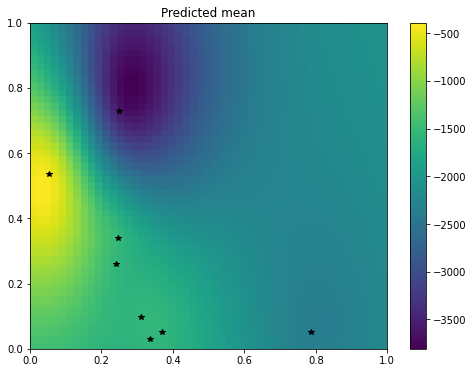

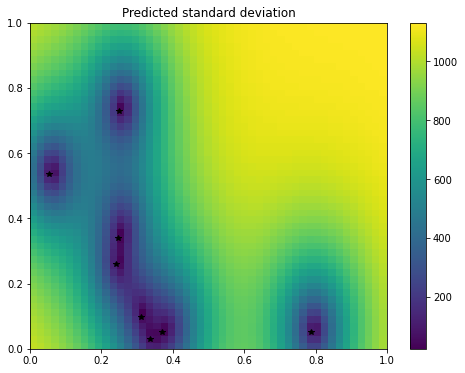

In [15]:
# call simple training function
model = train_model(train_X, train_Y, nu=1.5)

# call simple plotting function
if nx == 1:
  plot_model_predictions_1d(model, train_X, train_Y, 0, 1, 10001, 1);
elif nx == 2:
  plot_model_predictions_2d(model, train_X, train_Y, xL, xU);

### Helper Functions



In [ ]:
# specify inequality constraints of the form x(1) + ... + x(nx) <= 1 <-> (-1)*x(1) + ... + (-1)*x(nx) >= -1
indices = torch.tensor([i for i in range(nx)])
coefficients = torch.tensor([-1.0]*nx, dtype=torch.float64)
rhs = -1.0
inequality_constraints = [(indices, coefficients, rhs)]

# need ability to optimize aquisition function
def optimize_one_step_acq(model, train_X, train_Y):
  # define current acquisition function
  best_value = train_Y.max()
  EI = ExpectedImprovement(model=model, best_f=best_value)
  #UCB = UpperConfidenceBound(model, beta=4.0)
  # create hard bounds
  bounds = torch.tensor([(xL[j], xU[j]) for j in range(nx)]).T
  # find the next best theta
  if nx > 1:
    new_point_analytic, acq_value = optimize_acqf(acq_function=EI, bounds=bounds, q=1, num_restarts=20, raw_samples=1000, inequality_constraints=inequality_constraints, options={})
  else:
    new_point_analytic, acq_value = optimize_acqf(acq_function=EI, bounds=bounds, q=1, num_restarts=20, raw_samples=1000, options={})
  x_next = new_point_analytic[0,:]
  return x_next, acq_value

# run optimization routine and get next evaluation
def optimize_acq_and_get_observation(model, train_X, train_Y):
  # run optimization to get next candidate design point
  x_next, acq_value = optimize_one_step_acq(model, train_X, train_Y)
  # evaluate the true function at the next design
  y_next = f_max(x_next.numpy().tolist())
  return x_next, y_next, acq_value

Test out that the helper functions are working.

In [ ]:
x_next_test, y_next_test, acq_value = optimize_acq_and_get_observation(model, train_X, train_Y)
print(f"The next selected design is: {x_next_test.numpy().tolist()}")
print(f"The next evaluated point is: {y_next_test}")
print(f"The acq value at the next design point is: {acq_value.item()}")

The next selected design is: [0.0]
The next evaluated point is: -2201.259943372276
The acq value at the next design point is: 931.4536471045619


### Main Loop

Now we need to run the full BO loop. 

Trial: 1|Iteration: 1|Max value so far: -1557.677|Acquistion value 150.130
Trial: 1|Iteration: 2|Max value so far: -1557.677|Acquistion value 141.864
Trial: 1|Iteration: 3|Max value so far: -1557.677|Acquistion value 584.518
Trial: 1|Iteration: 4|Max value so far: -1557.677|Acquistion value 222.994
Trial: 1|Iteration: 5|Max value so far: -1557.677|Acquistion value 208.661
Trial: 1|Iteration: 6|Max value so far: -1557.677|Acquistion value 241.541
Trial: 1|Iteration: 7|Max value so far: -296.356|Acquistion value 161.611
Trial: 1|Iteration: 8|Max value so far: -296.356|Acquistion value 46.174
Trial: 1|Iteration: 9|Max value so far: -296.356|Acquistion value 13.328
Trial: 1|Iteration: 10|Max value so far: -296.356|Acquistion value 64.695
Trial: 1|Iteration: 11|Max value so far: -0.467|Acquistion value 325.202
Trial: 1|Iteration: 12|Max value so far: -0.467|Acquistion value 27.646
Trial: 1|Iteration: 13|Max value so far: -0.467|Acquistion value 123.086


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 14|Max value so far: -0.467|Acquistion value 138.076
Trial: 1|Iteration: 15|Max value so far: -0.467|Acquistion value 145.219
Trial: 1|Iteration: 16|Max value so far: -0.467|Acquistion value 144.399


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 17|Max value so far: -0.467|Acquistion value 137.865
Trial: 1|Iteration: 18|Max value so far: -0.467|Acquistion value 142.214
Trial: 1|Iteration: 19|Max value so far: -0.467|Acquistion value 154.030
Trial: 1|Iteration: 20|Max value so far: -0.467|Acquistion value 148.409
Trial: 1|Iteration: 21|Max value so far: -0.467|Acquistion value 141.310


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 22|Max value so far: -0.467|Acquistion value 150.178
Trial: 1|Iteration: 23|Max value so far: -0.467|Acquistion value 142.823


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 24|Max value so far: -0.467|Acquistion value 134.256


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 25|Max value so far: -0.467|Acquistion value 137.752


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 26|Max value so far: -0.467|Acquistion value 139.337
Trial: 1|Iteration: 27|Max value so far: -0.467|Acquistion value 133.832


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 28|Max value so far: -0.467|Acquistion value 127.883
Trial: 1|Iteration: 29|Max value so far: -0.467|Acquistion value 177.301


/usr/local/lib/python3.7/dist-packages/botorch/fit.py:155: RuntimeWarning: Fitting failed on all retries.
  warnings.warn("Fitting failed on all retries.", RuntimeWarning)


Trial: 1|Iteration: 30|Max value so far: -0.467|Acquistion value 225.060
Trial: 1|Iteration: 31|Max value so far: -0.467|Acquistion value 188.433
Trial: 1|Iteration: 32|Max value so far: -0.180|Acquistion value 1154.622
Trial: 1|Iteration: 33|Max value so far: -0.180|Acquistion value 489.528
Trial: 1|Iteration: 34|Max value so far: -0.180|Acquistion value 405.888
Trial: 1|Iteration: 35|Max value so far: -0.180|Acquistion value 323.221
Trial: 2|Iteration: 1|Max value so far: -1559.028|Acquistion value 488.551
Trial: 2|Iteration: 2|Max value so far: -1559.028|Acquistion value 370.788
Trial: 2|Iteration: 3|Max value so far: -1559.028|Acquistion value 298.014
Trial: 2|Iteration: 4|Max value so far: -293.203|Acquistion value 558.539
Trial: 2|Iteration: 5|Max value so far: -293.203|Acquistion value 123.314
Trial: 2|Iteration: 6|Max value so far: -293.203|Acquistion value 147.803
Trial: 2|Iteration: 7|Max value so far: -293.203|Acquistion value 347.045
Trial: 2|Iteration: 8|Max value so far: 

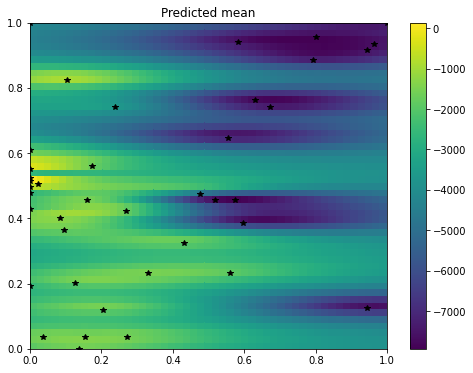

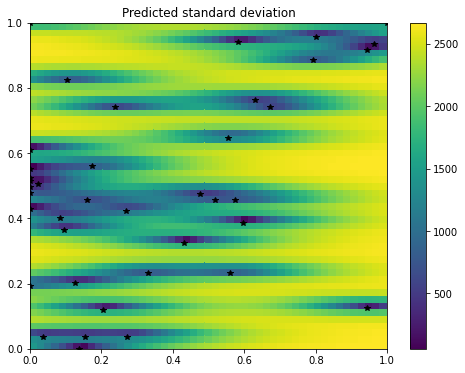

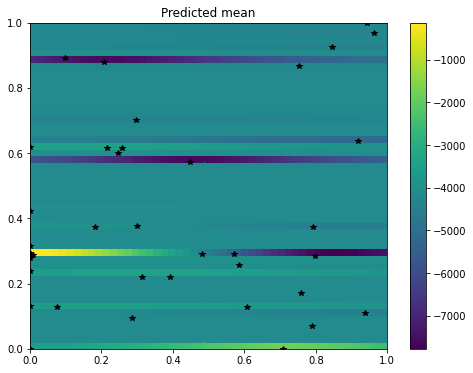

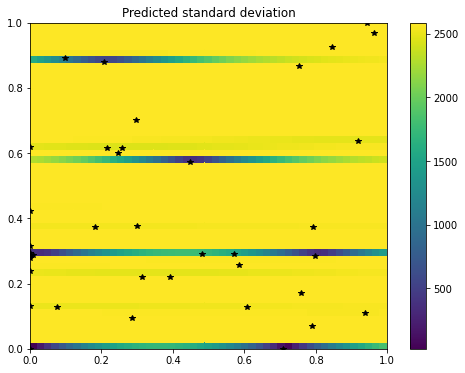

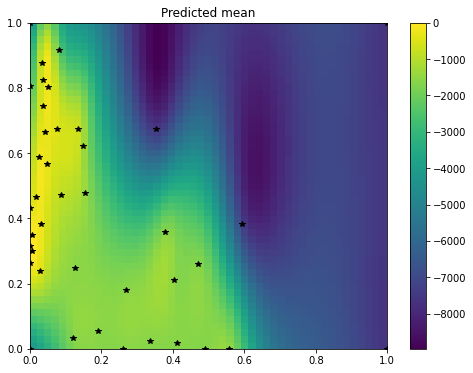

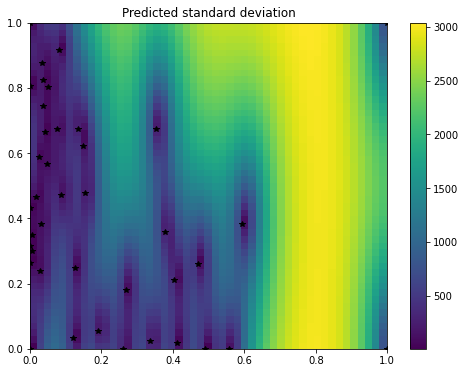

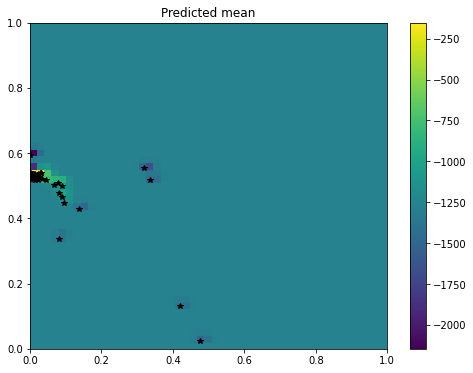

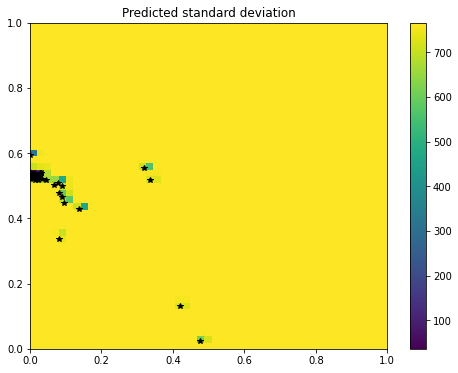

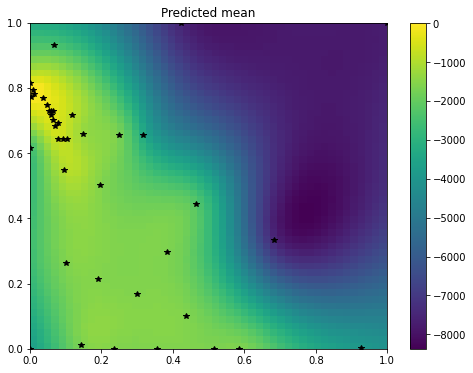

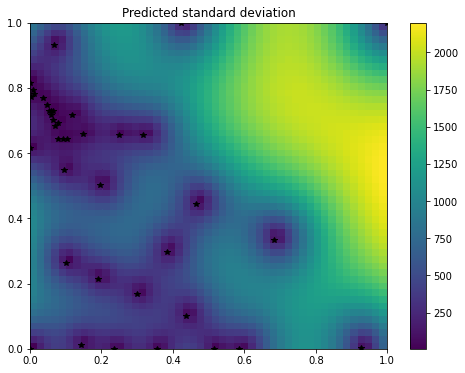

In [ ]:
### USER INPUTS

# set the number of initial samples, iterations, and trials
N_init = 5
N_iter = 35
N_trial = 5

# set value of hyperparameter in kernel
nu_val = 1.5


### MAIN LOOP

# initialize a list for best observed value
best_observed_all = []

# loop over number of trials
for trial in range(N_trial):
  # fix random seed
  numpy.random.seed(seed=trial)
  botorch.utils.sampling.manual_seed(seed=trial)

  # create empty arrays
  nx = xL.shape[0]
  x_history = numpy.empty((0,nx))
  y_history = numpy.empty((0,1))

  # create empty list for best observed value
  best_observed = []

  # loop over initial random samples
  for i in range(N_init):
    x_next = numpy.random.dirichlet(alpha=[1]*n_rxn)
    x_next = x_next[0:-1]
    y_next = f_max(x_next.tolist())
    x_history = numpy.append(x_history, x_next.reshape((1,-1)), axis=0)
    y_history = numpy.append(y_history, y_next.reshape((1,-1)), axis=0)
    best_observed.append(numpy.max(y_history).item()) # be sure to update best value

  # run main BO loop
  for i in range(N_iter):
    # convert data history to tensor
    train_X = torch.tensor(x_history)
    train_Y = torch.tensor(y_history)

    # call simple training function
    try:
      model = train_model(train_X, train_Y, nu=nu_val)
    except:
      print("Model training failed, so retained previous model")

    # optimize acqusition and get next observation
    x_next, y_next, acq_value = optimize_acq_and_get_observation(model, train_X, train_Y)

    # append to data history
    x_history = numpy.append(x_history, x_next.numpy().reshape((1,-1)), axis=0)
    y_history = numpy.append(y_history, y_next.reshape((1,-1)), axis=0)

    # update the best observed value
    best_observed.append(numpy.max(y_history).item())

    # print the current best max
    print('Trial: %d|Iteration: %d|Max value so far: %.3f|Acquistion value %.3f'%(trial+1, i+1, numpy.max(y_history), acq_value))

  # update the list of all trials
  best_observed_all.append(best_observed)

  # plot final prediction results, if possible
  train_X = torch.tensor(x_history)
  train_Y = torch.tensor(y_history)
  model = train_model(train_X, train_Y, nu=nu_val)
  if nx == 1:
    plot_model_predictions_1d(model, train_X, train_Y, npoints=1001);
    plot_model_predictions_1d(model, train_X, train_Y, 0, 0.1, npoints=1001, plot_train=0);
  elif nx == 2:
    plot_model_predictions_2d(model, train_X, train_Y, xL, xU);

# save the best data
#https://botorch.org/tutorials/closed_loop_botorch_only
import pandas as pd
y_best = numpy.asarray(best_observed_all)
df = pd.DataFrame()
for trial in range(N_trial):
  df["trial"+str(trial)] = y_best[trial,:]
# path = '/content/drive/My Drive/Colab Notebooks/InverseOptimizationFBA/ecoli_small/BO_results/BO_N_trial=' + str(N_trial) + '_N_init=' + str(N_init) + '_N_iter=' + str(N_iter) + '.csv'
path = '/content/drive/My Drive/Work/Project/BO4IO/BO4IO/case_study/FBA/ecoli_small/BO_results/BO_N_trial=' + str(N_trial) + '_N_init=' + str(N_init) + '_N_iter=' + str(N_iter) + '.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Find the best recommended point (one that maximizes the measured data) just for the final trial. 



In [ ]:
index = numpy.argmax(y_history)
x_rec = x_history[index,:]
x_rec

array([0.00780624, 0.79248113])

### Post-Processing

Plot the best observed value with confidence intervals. 

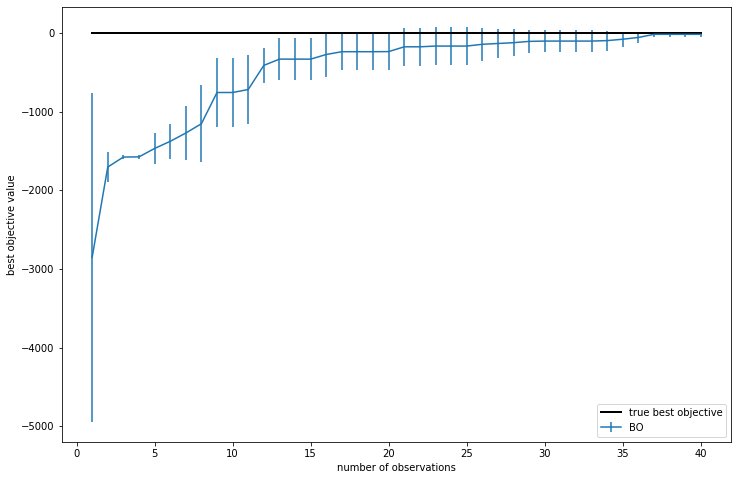

In [ ]:
def confidence_interval(y):
    return 1.96 * y.std(axis=0) / numpy.sqrt(N_trial)

GLOBAL_MAXIMUM = neg_loss_true

iters = numpy.arange(1, N_init + N_iter + 1)
y_best = numpy.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.errorbar(iters, y_best.mean(axis=0), yerr=confidence_interval(y_best), label="BO", linewidth=1.5)
plt.plot([1, N_init+N_iter], [GLOBAL_MAXIMUM]*2, 'k', label="true best objective", linewidth=2)
ax.set(xlabel='number of observations', ylabel='best objective value')
ax.legend(loc='lower right');
#ax.set_ylim(bottom=-100, top =100);

Create a dataframe with the generated data. 

In [ ]:
import pandas as pd
df = pd.DataFrame()
for i in range(nx):
  df["x"+str(i)] = x_history[:,i]
df["y"] = y_history

Save the dataframe as a CSV file with the proper path. 

In [ ]:
# path = '/content/drive/My Drive/Colab Notebooks/InverseOptimizationFBA/ecoli_small/BO_results/BO_N_init=' + str(N_init) + '_N_iter=' + str(N_iter) + '_seed=' + str(random_seed) + '.csv'
path = '/content/drive/My Drive/Work/Project/BO4IO/BO4IO/case_study/FBA/ecoli_small/BO_results/BO_N_init=' + str(N_init) + '_N_iter=' + str(N_iter) + '_seed=' + str(random_seed) + '.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

## Run Bayesian Optimization Loop (skopt)

In this section of the code, we run the entire Bayesian optimization (BO) loop using skopt, so we have more flexibility in terms of modeling types (e.g,. Gaussian process and Random Forests).

NOTE: This only works for 2d problems currently (wherein I explicitly rewrite the second coefficient as 1-x). 

In [ ]:
# Import functions
from skopt import gp_minimize, forest_minimize

# Define loss function for minimization problem (ONLY WORKS FOR 2 COEFFICIENTS)
from simulator import simulator
def f_min(x, solvername = 'gurobi', ind = 0):
  loss = simulator(c_vector=[x[0], 1.0-x[0]], n_exp=n_exp, n_rxn=n_rxn, n_pool=2, get_exp_input_results=get_exp_input_results, read_model_results=read_model_results, solvername = solvername, ind = ind)
  return loss

# Specify the fixed values
n_initial_points = 5
n_calls = 30
bounds = [(xL[i], xU[i]) for i in range(nx-1)]
acq_func = "EI"

# Define a helper function that let's us run Monte Carlo replicates
from functools import partial
def run(minimizer, n_iter=5):
    return [minimizer(func=f_min, dimensions=bounds, n_calls=n_calls, n_initial_points=n_initial_points, acq_func=acq_func, random_state=n)
            for n in range(n_iter)]

# Run with Gaussian process surrogate
res_gp = run(partial(gp_minimize, noise=1.0e-6), n_iter=5)

# Run with Random forest surrogate
res_rf = run(partial(forest_minimize, base_estimator="RF"), n_iter=5)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

Plot the convergence profiles. 

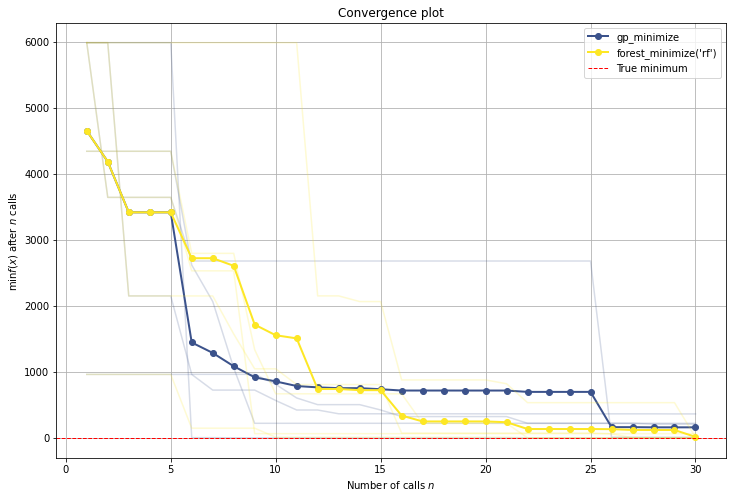

In [ ]:
from skopt.plots import plot_convergence
plt.figure(figsize=(12,8))
plot = plot_convergence(("gp_minimize", res_gp),
                        ("forest_minimize('rf')", res_rf),
                        true_minimum=-neg_loss_true)

In [ ]:
import pandas as pd
dfs = []
for j in range(5):
  df = pd.DataFrame()
  x_iters = numpy.array(res_rf[j].x_iters)
  y_iters = res_rf[j].func_vals
  for i in range(nx):
    if i == 0:
      df["x"+str(i)] = x_iters[:,i]
    else:
      df["x"+str(i)] = 1 - x_iters[:,0]
  df["y"] = y_iters
  dfs += [df]
with pd.ExcelWriter('BO_results/skopt_rf_Nexp=50_Nrxn=2.xlsx') as writer:
  for j in range(5):
    dfs[j].to_excel(writer, sheet_name='Random_seed' + str(j))

In [ ]:
-neg_loss_true

0.8003134070083721

## TEST IDEAS

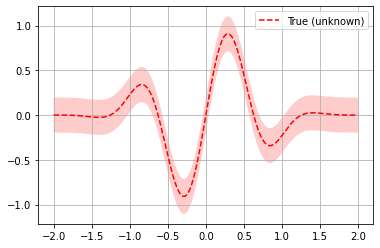

x^*=-0.3552, f(x^*)=-1.0079


In [ ]:
import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

print("x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun))

In [ ]:
res.fun

-1.0079192525224274

What if we tried to use a novelty search method wherein we search for a new behavior???

Maybe we should try a TPE or random forest (https://www.borealisai.com/research-blogs/tutorial-8-bayesian-optimization/). 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(x_history, y_history.squeeze())
print(regr.predict([[0.02, 0.98]]))

[-5.45546636]


In [ ]:
posterior = model.posterior(train_X)
print(posterior.mean - train_Y)
print(posterior.variance)

tensor([[-0.0110],
        [ 0.0141],
        [-0.0121],
        [ 0.1156],
        [-0.0131],
        [-0.0128],
        [-0.0081],
        [-0.0727]], dtype=torch.float64, grad_fn=<SubBackward0>)
tensor([[37.3696],
        [37.3692],
        [37.3696],
        [37.3696],
        [37.3696],
        [37.3696],
        [37.3696],
        [37.3692]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
